In [1]:
import os, sys
sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from tqdm import tqdm
import dask
import dask.array as da
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from utils.mmap_dataset import MMapIndexedDataset

from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import numpy as np


In [2]:
cluster = SLURMCluster(cores=8,
                    processes=4,
                    memory="32GB",
                    walltime="48:00:00",
                    # project="fiete",
                    queue="normal",
                    job_extra_directives=["--output=logs/%j.out", "--error=logs/%j.out"]
                    )
cluster.scale(jobs=16)
print("Dashboard: ", cluster.dashboard_link)

client = Client(cluster)
client

Dashboard:  http://172.16.20.122:8787/status


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.16.20.122:8787/status,
Dashboard: http://172.16.20.122:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.20.122:37617,Workers: 0
Dashboard: http://172.16.20.122:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:


dataset = MMapIndexedDataset('/om/user/sunnyd/data/datasets--EleutherAI--pile-standard-pythia-preshuffled-merged/document', skip_warmup = True)
@dask.delayed
def load_chunk(path, ptr, total_size, dtype):
    bin_buffer_mmap = np.memmap(path, mode="r", order="C")
    bin_buffer = memoryview(bin_buffer_mmap)
    data = np.frombuffer(bin_buffer, 
                         dtype=dtype, 
                         count=total_size, 
                         offset=ptr).reshape(-1, 2049)
    return data
    

def mmap_dask_array(blocksize=1000, offset=0, max=50000):
    load = dask.delayed(load_chunk)
    chunks = []
    max_idx = min(max, len(dataset))
    for index in tqdm(range(offset, max_idx, blocksize)):
        chunk_size = min(blocksize, max_idx - index)
        path = '/om/user/sunnyd/data/datasets--EleutherAI--pile-standard-pythia-preshuffled-merged/document.bin'
        ptr = dataset._index._pointers[index]
        dtype = dataset._index.dtype
        count = np.sum(dataset._index._sizes[index:index+chunk_size])
        # Truncate the last chunk if necessary
        chunk = dask.array.from_delayed(
            load(path, ptr, count, dtype),
            shape=(chunk_size, 2049),
            dtype=dataset[0].dtype
        )
        chunks.append(chunk)
    return da.concatenate(chunks, axis=0)




    reading sizes...
    reading pointers...
    reading document index...
    creating numpy buffer of mmap...
    creating memory view of numpy buffer...


In [4]:
x1 = mmap_dask_array(20000, 10000 * 1024, 11000 * 1024)


100%|██████████| 52/52 [00:00<00:00, 325.25it/s]


In [5]:
ex = x1[::20, :288].compute()

# GZip

In [10]:
tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="/om/user/sunnyd/transformers_cache",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:
import zlib
def zcomplexity(x):
    orig = tokenizer.decode(x).encode('utf-8')
    enc = zlib.compress(orig)
    return len(enc) / len(orig) 
zcomp_n = np.vectorize(complexity, signature='(n)->()')
zcomp_complex = zcomp_n(ex[:, :288])

In [38]:
test = """8 */
	i_fpo,			/* 0xd9 */
	i_fpo,			/* 0xda */
	i_fpo,			/* 0xdb */
	i_fpo,			/* 0xdc */""".encode('utf-8')
len(zlib.compress(test)) / len(test)

0.4659090909090909

(array([5.5000e+01, 5.8100e+02, 1.4660e+03, 3.0520e+03, 4.5260e+03,
        7.4340e+03, 1.7453e+04, 1.5153e+04, 1.4640e+03, 1.6000e+01]),
 array([0.00694444, 0.09027778, 0.17361111, 0.25694444, 0.34027778,
        0.42361111, 0.50694444, 0.59027778, 0.67361111, 0.75694444,
        0.84027778]),
 <BarContainer object of 10 artists>)

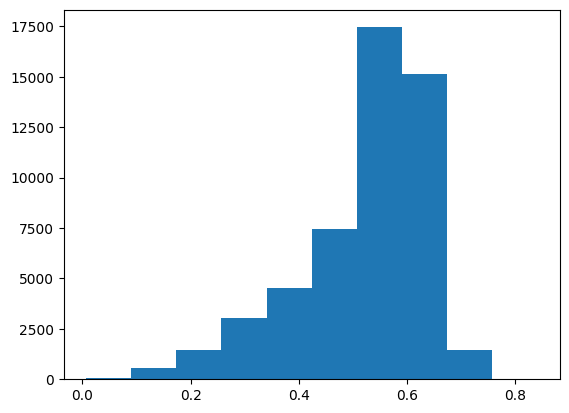

In [35]:
plt.hist(zcomp_complex)

In [39]:
np.save('zcomplexity', zcomp_complex)

# Uniqueness based compression

In [6]:
def complexity(x):
    return len(np.unique(x)) / len(x)
comp_n = np.vectorize(complexity, signature='(n)->()')
comp_complex = comp_n(ex[:, :288])

(array([5.5000e+01, 5.8100e+02, 1.4660e+03, 3.0520e+03, 4.5260e+03,
        7.4340e+03, 1.7453e+04, 1.5153e+04, 1.4640e+03, 1.6000e+01]),
 array([0.00694444, 0.09027778, 0.17361111, 0.25694444, 0.34027778,
        0.42361111, 0.50694444, 0.59027778, 0.67361111, 0.75694444,
        0.84027778]),
 <BarContainer object of 10 artists>)

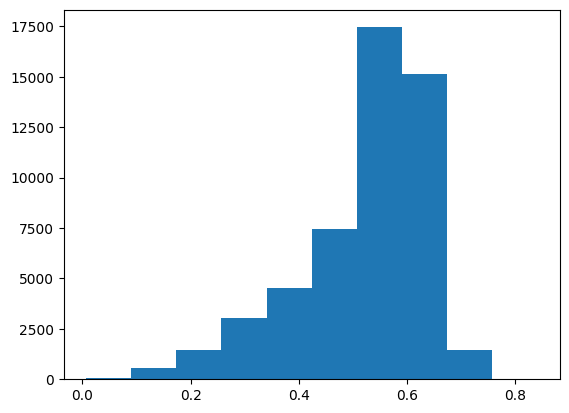

In [7]:
plt.hist(comp_complex)

In [8]:
np.save('complexity_unique', comp_complex)

In [9]:
x1 = mmap_dask_array(20000, 0, 1000 * 1024)

100%|██████████| 52/52 [00:00<00:00, 936.42it/s]


In [10]:
def complexity(x):
    comp = []
    seen = set()
    for i in range(1, 256):
        seen.add(x[32+i])
        comp.append(len(seen) / i)
    return np.array(comp)
# comp_n = np.vectorize(complexity, signature='(n)->(m)')
# comp_complex = comp_n(ex)
res = np.apply_along_axis(complexity, 1, x1[::20].compute())

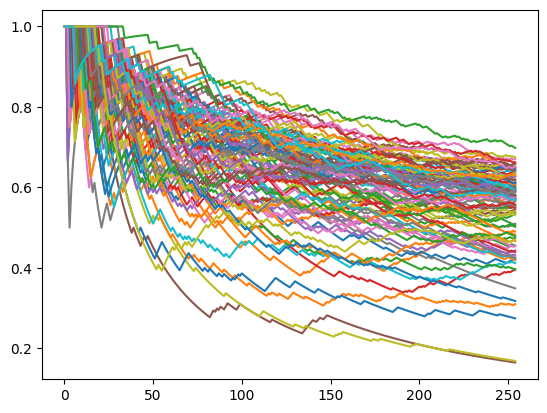

In [11]:
plt.plot(res[:100].T);

In [12]:
np.save('cum_complexity', res)